#Prep

In [1]:
!pip install torch
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import json
from PIL import Image, ImageOps, ImageDraw
import os
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_PATH = "/content/drive/MyDrive/ARP/circles"

#File Manipulation

In [7]:
def get_dataset(dir_path, prt=False):
    with open(os.path.join(dir_path, "COCO.json")) as ann:
        data = json.load(ann)
    image_list = data['images']
    annotations = data['annotations']
    categories = data['categories']
    if prt:
        print(data, '\n')
        print(image_list, '\n')
        print(annotations, '\n')
        print(categories)
    return image_list, annotations, categories

In [8]:
train_image_list, train_annotations, train_categories = get_dataset(os.path.join(DATASET_PATH, 'train'), prt=True)

{'images': [{'id': 1, 'width': 200, 'height': 200, 'file_name': 'image_1.png'}, {'id': 2, 'width': 200, 'height': 200, 'file_name': 'image_2.png'}, {'id': 3, 'width': 200, 'height': 200, 'file_name': 'image_3.png'}, {'id': 4, 'width': 200, 'height': 200, 'file_name': 'image_4.png'}, {'id': 5, 'width': 200, 'height': 200, 'file_name': 'image_5.png'}, {'id': 6, 'width': 200, 'height': 200, 'file_name': 'image_6.png'}, {'id': 7, 'width': 200, 'height': 200, 'file_name': 'image_7.png'}, {'id': 8, 'width': 200, 'height': 200, 'file_name': 'image_8.png'}, {'id': 9, 'width': 200, 'height': 200, 'file_name': 'image_9.png'}, {'id': 10, 'width': 200, 'height': 200, 'file_name': 'image_10.png'}, {'id': 11, 'width': 200, 'height': 200, 'file_name': 'image_11.png'}, {'id': 12, 'width': 200, 'height': 200, 'file_name': 'image_12.png'}, {'id': 13, 'width': 200, 'height': 200, 'file_name': 'image_13.png'}, {'id': 14, 'width': 200, 'height': 200, 'file_name': 'image_14.png'}, {'id': 15, 'width': 200, '

#Train

##Create Dataset

In [9]:
ROI_SIZE = 32

In [10]:
def crop_img(img, ann):
    bbox = ann['bbox']
    cropped = img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    return np.asfarray(Image.fromarray(cropped).resize((ROI_SIZE, ROI_SIZE)))

In [11]:
static_ball_mask = [1. ,1., 0. ,0.]
dynamic_ball_mask = [0., 0., 1., 1.]

In [12]:
def make_target_tensor(annotations):
    targets = []
    masks = []
    for ann in annotations:
        bbox = ann['bbox']
        tx = (ann['obj_params']['x1'] - bbox[0]) * (32/bbox[2])
        ty = (ann['obj_params']['y1'] - bbox[1]) * (32/bbox[3])
        if ann['category_id'] == 3:
            targets.append([tx, ty, 0., 0.])
            masks.append(static_ball_mask)
        elif ann['category_id'] == 6:
            targets.append([0., 0. ,tx, ty])
            masks.append(dynamic_ball_mask)
    return targets, masks

In [71]:
def make_tensors(image_list, annotations, categories, prt=False):
    X = []
    y = []
    mask = []
    for img_info in image_list:
        im_view = np.asarray(ImageOps.grayscale(Image.open(os.path.join(DATASET_PATH, "train", img_info['file_name']))))
        im_ann = list(filter(lambda im: im['image_id'] == img_info['id'], annotations))
        one_image_y, one_img_mask = make_target_tensor(im_ann)
        y.extend(one_image_y)
        mask.extend(one_img_mask)
        for ia in im_ann:
            ci = crop_img(im_view, ia)
            X.append(ci.flatten())

    X = torch.tensor(X, dtype=torch.float32 ,requires_grad=True)
    y = torch.tensor(y, dtype=torch.float32 ,requires_grad=True)
    mask = torch.tensor(mask, dtype=torch.float32 ,requires_grad=True)
    if prt:
        print(X, X.shape)
        print(y, y.shape)
        print(mask, mask.shape)
    return X, y, mask

In [72]:
train_X, train_y, train_mask = make_tensors(train_image_list, train_annotations, train_categories, prt=True)

tensor([[161., 161., 161.,  ..., 160., 160., 160.],
        [159., 158., 169.,  ..., 161., 161., 161.],
        [159., 105.,   9.,  ..., 146., 145., 145.],
        ...,
        [163., 162., 162.,  ..., 160., 160., 160.],
        [146., 146., 146.,  ..., 149., 148., 148.],
        [149., 149., 149.,  ..., 148., 148., 147.]], requires_grad=True) torch.Size([943, 1024])
tensor([[14.9333, 14.9333,  0.0000,  0.0000],
        [14.6667, 14.6667,  0.0000,  0.0000],
        [14.2222, 14.2222,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, 14.6667, 14.6667],
        [ 0.0000,  0.0000, 14.9333, 14.9333],
        [ 0.0000,  0.0000, 14.5455, 14.5455]], requires_grad=True) torch.Size([943, 4])
tensor([[1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        ...,
        [0., 0., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 1., 1.]], requires_grad=True) torch.Size([943, 4])


##Create Model

In [60]:
class objectMapper(nn.Module):
    def __init__(self, output_size):
        super(objectMapper, self).__init__()
        self.fc1 = nn.Linear(ROI_SIZE*ROI_SIZE, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    

In [61]:
def train_loop(model, X, y, mask, criterion, optimizer, epochs):
        for ep in range(epochs):
            print(f"Epoch: {ep+1}")
            preds = model.forward(X)
            preds = preds * mask
            loss = criterion(preds, y)
            print(f"Loss: {loss}")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [62]:
mapper = objectMapper(len(static_ball_mask))
print(mapper)

objectMapper(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


In [63]:
def show_object(im, bbox, center):
    cropped = im[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
    cropped = np.asfarray(Image.fromarray(cropped).resize((32, 32)))
    plt.imshow(cropped)
    plt.plot([center[0].item()], [center[1].item()], 'ro')

In [64]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(mapper.parameters(), lr=1e-5, momentum=.9)
epochs = 200

In [ ]:
train_loop(mapper, train_X, train_y, train_mask, criterion, optimizer, epochs)

######Result Example

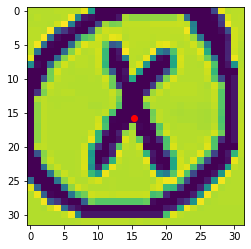

In [66]:
img_info = train_image_list[0]
im_view = np.asarray(ImageOps.grayscale(Image.open(os.path.join(DATASET_PATH, "train", img_info['file_name']))))
im_ann = list(filter(lambda im: im['image_id'] == img_info['id'], train_annotations))
ci = crop_img(im_view, im_ann[0])
pred = mapper.forward(train_X)
show_object(im_view, im_ann[0]['bbox'], pred[0, :])

#Test

In [73]:
test_image_list, test_annotations, test_categories = get_dataset(os.path.join(DATASET_PATH, 'test'), prt=True)

{'images': [{'id': 1, 'width': 200, 'height': 200, 'file_name': 'image_1.png'}, {'id': 2, 'width': 200, 'height': 200, 'file_name': 'image_2.png'}, {'id': 3, 'width': 200, 'height': 200, 'file_name': 'image_3.png'}, {'id': 4, 'width': 200, 'height': 200, 'file_name': 'image_4.png'}, {'id': 5, 'width': 200, 'height': 200, 'file_name': 'image_5.png'}, {'id': 6, 'width': 200, 'height': 200, 'file_name': 'image_6.png'}, {'id': 7, 'width': 200, 'height': 200, 'file_name': 'image_7.png'}, {'id': 8, 'width': 200, 'height': 200, 'file_name': 'image_8.png'}, {'id': 9, 'width': 200, 'height': 200, 'file_name': 'image_9.png'}, {'id': 10, 'width': 200, 'height': 200, 'file_name': 'image_10.png'}, {'id': 11, 'width': 200, 'height': 200, 'file_name': 'image_11.png'}, {'id': 12, 'width': 200, 'height': 200, 'file_name': 'image_12.png'}, {'id': 13, 'width': 200, 'height': 200, 'file_name': 'image_13.png'}, {'id': 14, 'width': 200, 'height': 200, 'file_name': 'image_14.png'}, {'id': 15, 'width': 200, '

In [74]:
test_X, test_y, test_mask = make_tensors(test_image_list, test_annotations, test_categories, prt=True)

tensor([[  0.,   0.,   0.,  ..., 159., 159., 160.],
        [156., 156., 156.,  ..., 154., 154., 154.],
        [144., 144., 144.,  ..., 141., 141., 141.],
        ...,
        [151., 151., 151.,  ..., 151., 151., 151.],
        [156., 156., 155.,  ..., 156., 156., 156.],
        [161., 161., 161.,  ..., 161., 160., 160.]], requires_grad=True) torch.Size([196, 1024])
tensor([[14.5455, 14.5455,  0.0000,  0.0000],
        [14.0000, 14.0000,  0.0000,  0.0000],
        [14.5455, 14.5455,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 14.2222, 14.2222],
        [14.2222, 14.2222,  0.0000,  0.0000],
        [14.2222, 14.2222,  0.0000,  0.0000],
        [14.5455, 14.5455,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 14.9333, 14.9333],
        [ 0.0000,  0.0000, 15.0000, 15.0000],
        [ 0.0000,  0.0000, 14.5455, 14.5455],
        [ 0.0000,  0.0000, 14.4000, 14.4000],
        [14.8571, 14.8571,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 14.0000, 14.0000],
        [ 0.0000,  0.0000, 14.66

In [102]:
def test_loop(model, X, annotations, image_list):
    predictions = model.forward(X)
    image_dict = {}
    for pred, ann in zip(predictions, annotations):
        if ann['category_id'] == 3:
            center = pred[0:2]
        elif ann['category_id'] == 6:
            center = pred[2:4]
        bbox = ann['bbox']
        tx = round(center[0].item() * (bbox[2]/32) + bbox[0])
        ty = round(center[1].item() * (bbox[3]/32) + bbox[1])
        if ann['image_id'] not in image_dict:
            image_dict[ann['image_id']] = []
        image_dict[ann['image_id']].append((tx, ty))
    
    # os.mkdir(os.path.join(DATASET_PATH, 'test', 'results'))
            
    for im_id, centers in image_dict.items():
        #Create Image object
        im_info = list(filter(lambda im: im['id'] == im_id, image_list))[0]
        im = Image.open(os.path.join(DATASET_PATH, 'test', im_info['file_name']))

        #Draw line
        draw = ImageDraw.Draw(im)
        draw.point(centers, fill='red')

        #Show image
        im.save(os.path.join(DATASET_PATH, 'test', 'results', im_info['file_name']))

In [103]:
test_loop(mapper, test_X, test_annotations, test_image_list)